# SARIMA Method for Forecasting Product Sales
<style>
    .text {
        text-decoration: none
    }
</style>

## Table of Contens
1. [DATA LOADING AND OVERIEW](#data)
- [Import Necessary Librairies](#libra)
- [Loading Data](#load)
- [Display Data Frame](#display)
2. [Time series analysis](#analysis)
- [Visualisation of daily sold products](#day)
- [Visualisation of monthly sold products](#month)
- [Seasonality, Trend and Noise](#trend)
- [Future Sales Forecasting with SARIMA model](#future)
- [Checks for Stationarity of the time serie](#stationarity)
- [Autocorrelation in time series data](#Autocorrelation)
- [Parameters estimation & model building](#build)
- [Diagnostics of residuals](#diagnostics)
- [Forecasting](#forecast)
3. [Model evaluation](#evaluation)
- [Visualisation of monthly sold products](#test-month)

### DATA LOADING AND OVERIEW <a id="data"></a>
####  Import Necessary Librairies <a id="libra"></a>

In [1]:
import numpy as np 
# Import pandas for data (csv) manipulation
import pandas as pd 
# Import matplotlib for plotting
import matplotlib.pyplot as plt
# import seaborn for more plotting options(built on top of matplotlib)
import seaborn as sns
#Module of the IPython library to display rich content objects in notebooks.
from IPython import display
#Python library for generating keyword clouds from text.
from wordcloud import WordCloud
import datetime 
import matplotlib as mpl
#Module of the statsmodels library for analyzing seasonal decay in time series.
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ARIMA
#A function in the pmdarima library to automatically determine the best parameters for the ARIMA model.
from pmdarima.arima import auto_arima

#### Loading Data <a id="load"></a>

In [2]:
df=pd.read_csv('household_power_consumption.txt',delimiter=';',index_col=[0], parse_dates=[0])
df.head()

C:\Users\vudin\AppData\Local\Temp\ipykernel_7764\2565919472.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('household_power_consumption.txt',delimiter=';',index_col=[0], parse_dates=[0])
C:\Users\vudin\AppData\Local\Temp\ipykernel_7764\2565919472.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df=pd.read_csv('household_power_consumption.txt',delimiter=';',index_col=[0], parse_dates=[0])


,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,,,,,
2006-12-16,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
df['Global_active_power'] = df['Global_active_power'].replace('?', np.nan)

In [4]:
df['Global_active_power'] = df['Global_active_power'].astype(float)

In [5]:
split_date = '26-Nov-2009'
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

In [6]:
test

,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,,,,,
2009-11-27,00:00:00,0.420,0.214,242.480,1.800,0.000,0.000,0.0
2009-11-27,00:01:00,0.416,0.212,242.290,1.800,0.000,0.000,1.0
2009-11-27,00:02:00,0.416,0.216,243.020,1.800,0.000,0.000,1.0
2009-11-27,00:03:00,0.414,0.216,243.240,1.800,0.000,0.000,0.0
2009-11-27,00:04:00,0.410,0.214,242.860,1.800,0.000,0.000,1.0
...,...,...,...,...,...,...,...,...
2010-11-26,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2010-11-26,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0


### Time series analysis <a id="analysis"></a>
#### Visualisation of daily sold products <a id="day"></a>

In [7]:
train['Date'] = pd.to_datetime(train.index)
test['Date'] = pd.to_datetime(test.index)
train['Global_active_power'] = pd.Series(train['Global_active_power'], dtype='float64')
test['Global_active_power'] = pd.Series(test['Global_active_power'], dtype='float64')


In [8]:
train['Date'] = train['Date'].apply(lambda x: x.to_pydatetime())
#save a copy of sales_train
df_train=train.copy()

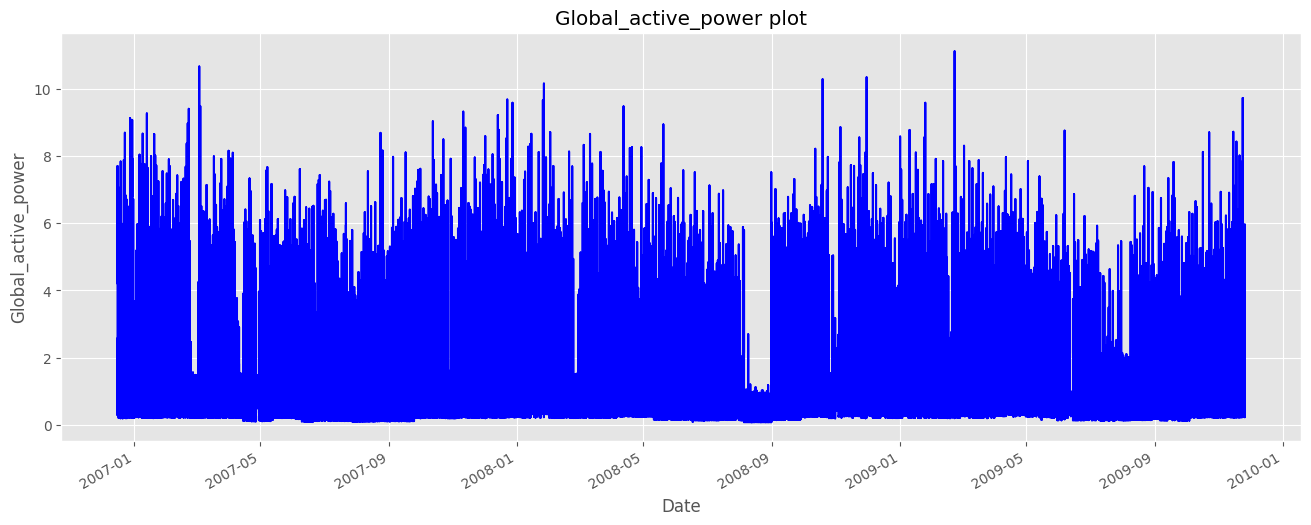

In [9]:
plt.style.use('ggplot')
ax2 = train['Global_active_power'].plot(figsize=(16,6),color='blue')
# Set the title
ax2.set_title('Global_active_power plot');
# Specify the x-axis label 
ax2.set_xlabel('Date')
# Specify the y-axis label 
ax2.set_ylabel('Global_active_power')
plt.show()

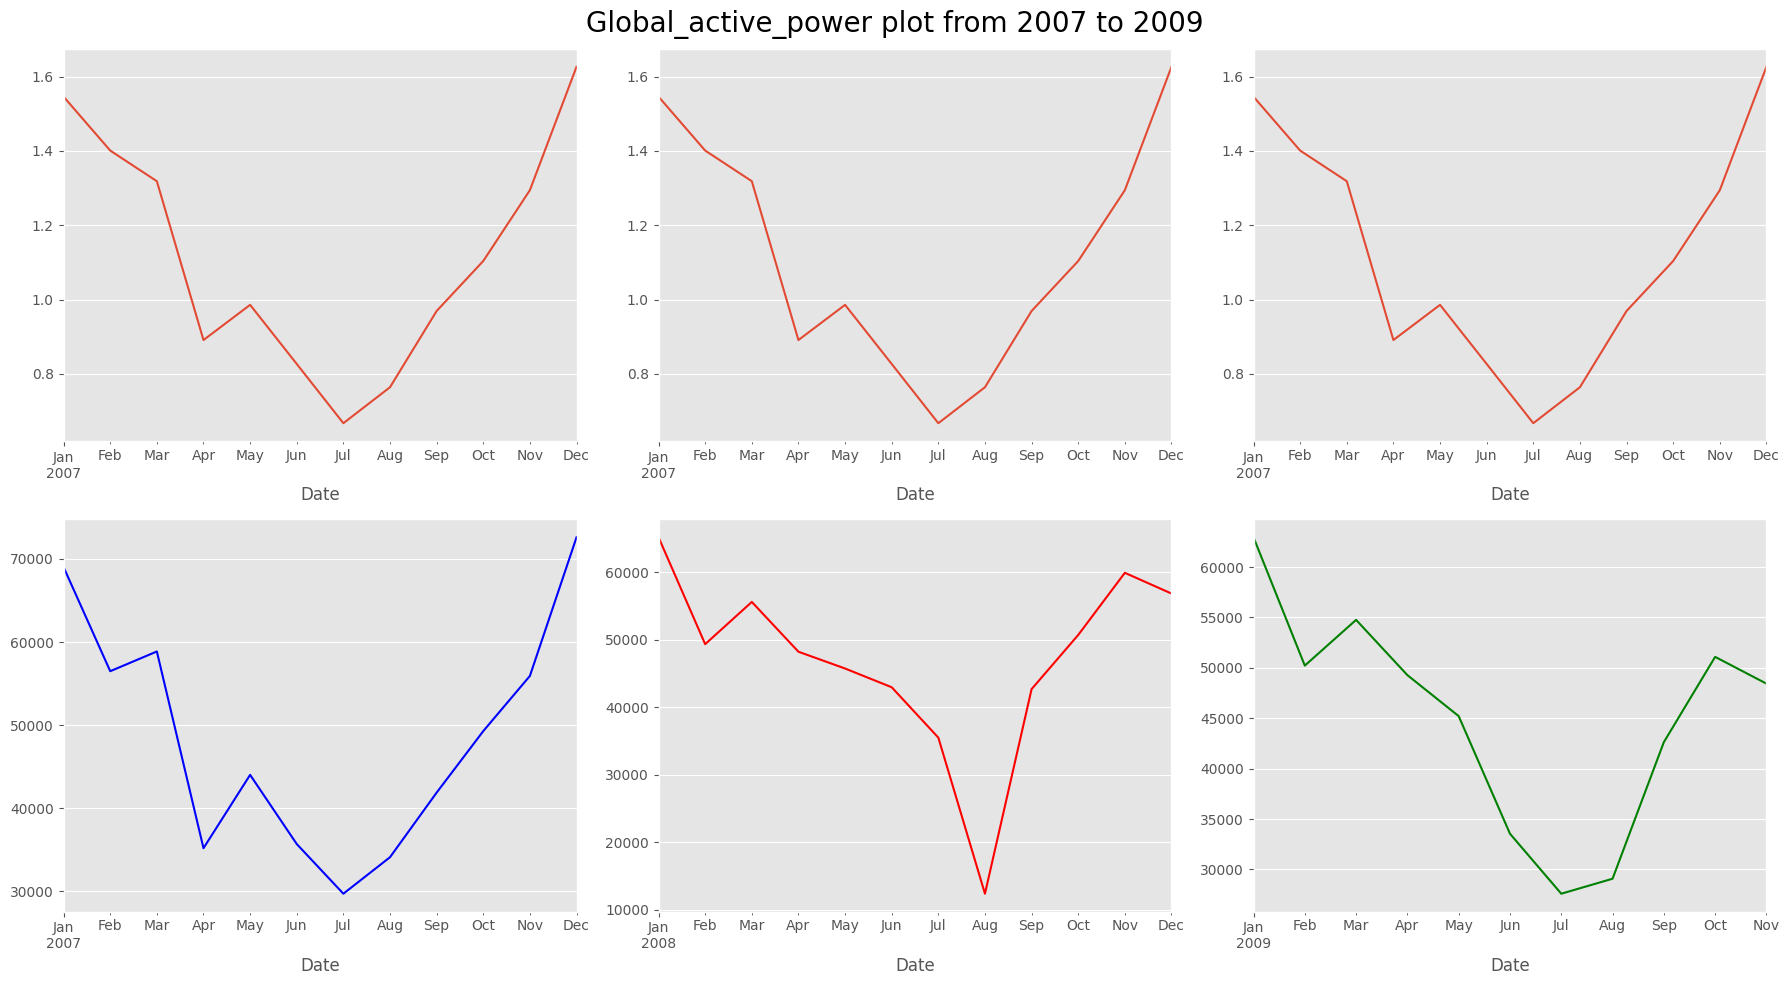

In [10]:
#creates an image containing a grid of sub-axis with 2 rows and 3 columns, and the image size is (18, 10).
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
#plot the 'Quantity' column in the DataFrame sales_train for 2014,2015,2016.
train.loc['2007','Global_active_power'].resample('M').mean().plot(ax=ax[0,0])

train.loc['2007','Global_active_power'].resample('M').mean().plot(ax=ax[0,1])

train.loc['2007','Global_active_power'].resample('M').mean().plot(ax=ax[0,2])

#Plot a graph of total sales in column 'Quantity' for 20142015,2016
train.loc['2007','Global_active_power'].resample('M').sum().plot( ax=ax[1,0],color='blue')
train.loc['2008','Global_active_power'].resample('M').sum().plot( ax=ax[1,1],color='red')
train.loc['2009','Global_active_power'].resample('M').sum().plot( ax=ax[1,2],color='green')
#title 
plt.suptitle('Global_active_power plot from 2007 to 2009',fontsize=20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.92, 
                    wspace=0.4, 
                    hspace=0.4)

fig.tight_layout()
plt.show()

#### Visualisation of monthly sold products <a id="month"></a>

In [11]:
#extract month information and convert data type
df_train['month'] = df_train['Date'].dt.to_period('M')
df_train['month'] = df_train['month'].astype(str)
dff2=df_train.copy()
df_train['month'] = pd.to_datetime(df_train['month'])

In [12]:
dff_train = df_train.groupby(['month']).agg({'Global_active_power':'sum'})
dff_train['month'] = dff_train.index
dff_train.drop(['month'],axis=1,inplace=True)
dff_train.rename(columns = {'Global_active_power':'Global_active_power_month'}, inplace = True)

In [13]:
dff_train

,Global_active_power_month
month,
2006-12-01,41813.282
2007-01-01,69011.862
2007-02-01,56488.886
2007-03-01,58862.192
2007-04-01,35181.466
2007-05-01,44008.872
2007-06-01,35682.828
2007-07-01,29703.830
2007-08-01,34096.460


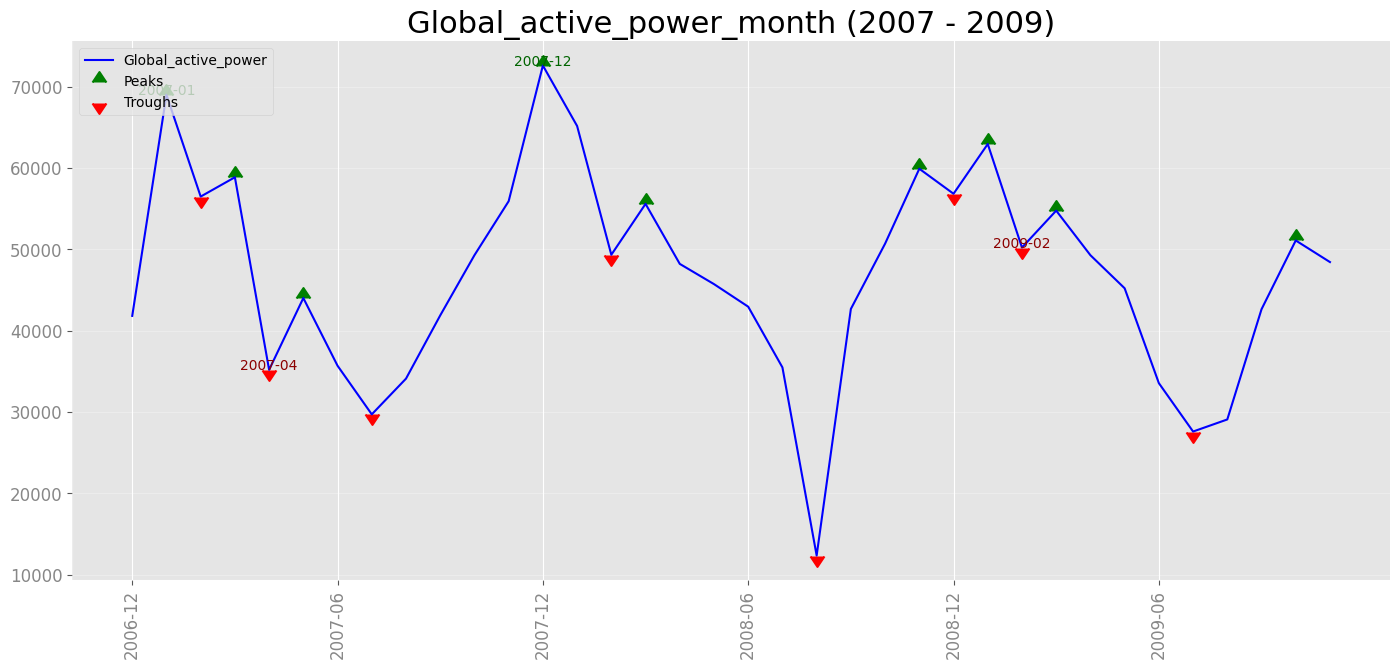

In [14]:
dff2=dff2.groupby(['month']).agg({'Global_active_power':'sum'})
dff2['month'] = dff2.index
dff2.rename(columns = {'Global_active_power':'Global_active_power_month'}, inplace = True)
# Get the Peaks and Troughs
data = dff2['Global_active_power_month'].values
doublediff = np.diff(np.sign(np.diff(data)))
peak_locations = np.where(doublediff == -2)[0] + 1

doublediff2 = np.diff(np.sign(np.diff(-1*data)))
trough_locations = np.where(doublediff2 == -2)[0] + 1

# Draw Plot
plt.figure(figsize=(17,7))
plt.plot('month', 'Global_active_power_month', data=dff2, color='blue', label='Global_active_power')
plt.scatter(dff2.month[peak_locations], dff2.Global_active_power_month[peak_locations], marker=mpl.markers.CARETUPBASE, color='green', s=100, label='Peaks')
plt.scatter(dff2.month[trough_locations], dff2.Global_active_power_month[trough_locations], marker=mpl.markers.CARETDOWNBASE, color='red', s=100, label='Troughs')

# Annotate
for t, p in zip(trough_locations[1::5], peak_locations[::3]):
    plt.text(dff2.month[p], dff2.Global_active_power_month[p]+15, dff2.month[p], horizontalalignment='center', color='darkgreen')
    plt.text(dff2.month[t], dff2.Global_active_power_month[t]-35, dff2.month[t], horizontalalignment='center', color='darkred')
# Decoration
xtick_location = dff2.index.tolist()[::6]
xtick_labels = dff2.month.tolist()[::6]
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=90, fontsize=12, alpha=.7)
plt.title("Global_active_power_month (2007 - 2009)", fontsize=22)
plt.yticks(fontsize=12, alpha=.7)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper left')
plt.grid(axis='y', alpha=.3)
plt.show()

#### Seasonality, Trend and Noise <a id="trend"></a>

In [15]:
decomposition=seasonal_decompose(dff_train, model = 'additive')
# Extract the trend and seasonal components
trend = decomposition.trend
seasonal = decomposition.seasonal
sales_decomposed = pd.DataFrame(np.c_[trend, seasonal], index=dff_train.index, columns=['trend', 'seasonal'])

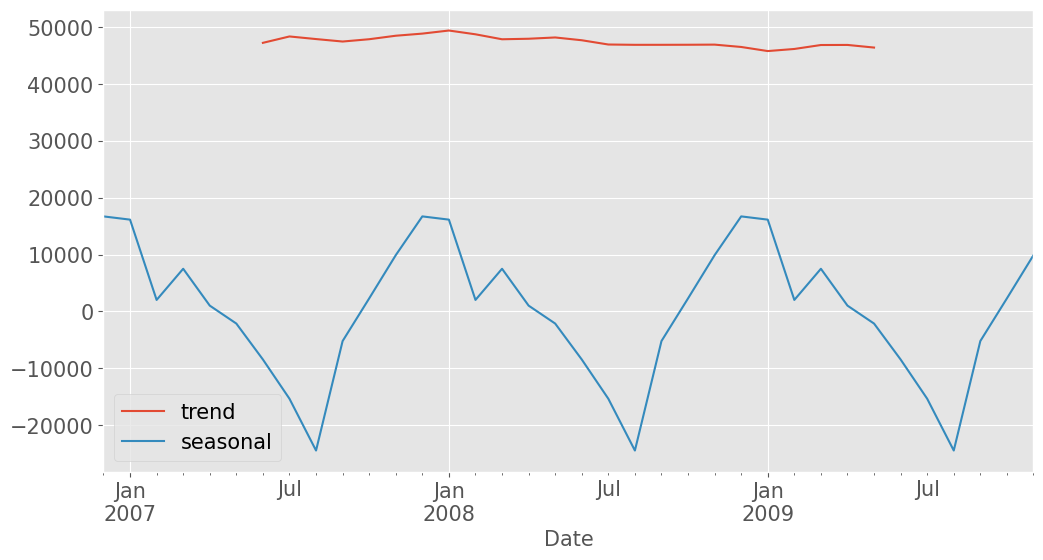

In [16]:
# Plot the values of the sales_decomposed DataFrame
ax = sales_decomposed.plot(figsize=(12, 6), fontsize=15)

# Specify axis labels
ax.set_xlabel('Date', fontsize=15)
plt.legend(fontsize=15)
plt.show()

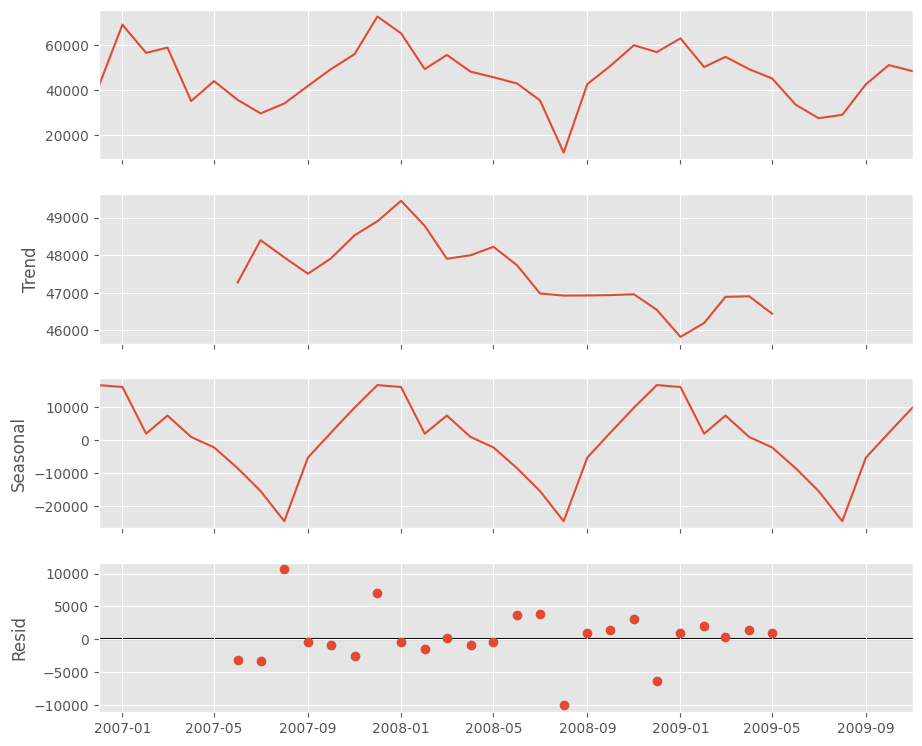

In [17]:
# seasonal_decompose for additive model
seasonal_decompose(dff_train, model = 'additive').plot().set_size_inches(10, 8)

### Future Sales Forecasting with SARIMA model <a id="future"></a>
#### Checks for Stationarity of the time serie <a id="stationarity"></a>

There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary. Here, i will use Augmented Dickey Fuller test.The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [18]:
result = adfuller(dff_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.529868
p-value: 0.000000
Critical Values:
	1%: -3.689
	5%: -2.972
	10%: -2.625


#### Autocorrelation in time series data <a id="Autocorrelation"></a>
In order to figure out the parameters p,d,q,P,D,Q of SARIMA model we would need to plot the ACF and PACF plots.
ACF stands for Auto Correlation Function and PACF stands for Partial Auto Correlation Function.

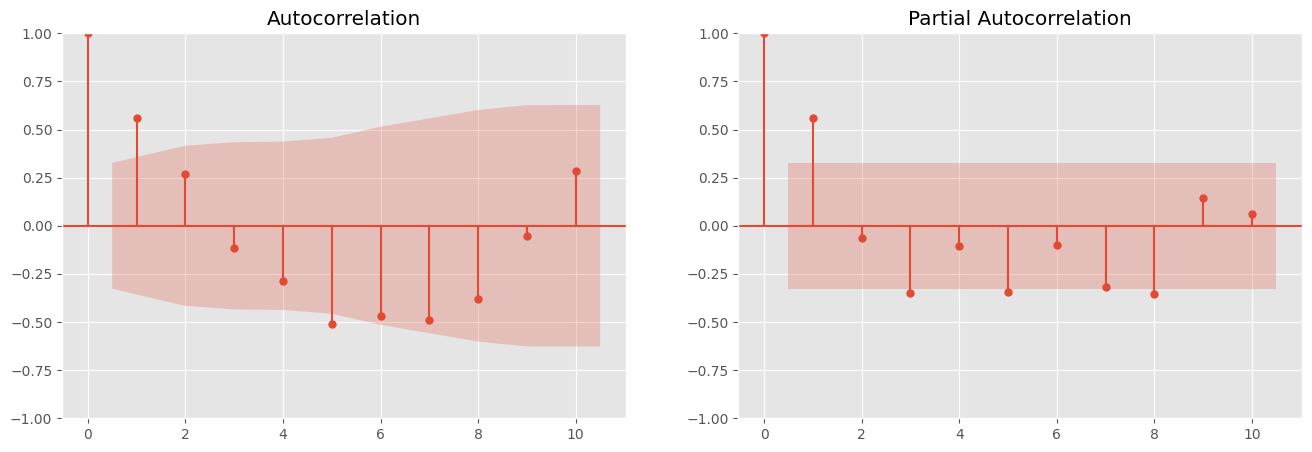

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_acf(dff_train,lags=10, ax=axes[0])
plot_pacf(dff_train,lags=10, ax=axes[1])
plt.show()

#### Parameters estimation & model building <a id="build"></a>

In [20]:
model=auto_arima(dff_train, start_p = 0, start_q = 0,D=0, m = 12, seasonal = True, test = "adf",  trace = True, alpha = 0.05, information_criterion = 'aic', suppress_warnings = True, 
                    stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=763.994, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=763.065, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=755.366, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=744.458, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=inf, Time=0.02 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=745.597, Time=0.05 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=745.717, Time=0.07 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=743.769, Time=0.05 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=745.608, Time=0.05 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=747.595, Time=0.20 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=762.427, Time=0.01 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=745.558, Time=0.06 sec
 ARIMA(0,2,2)(1,0,0)[12]             : AIC=746.078, Time=0.04 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,2,1)(1,0,0)[12] intercept   : AI

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   36
Model:             SARIMAX(0, 2, 1)x(1, 0, [], 12)   Log Likelihood                -368.885
Date:                             Sat, 15 Jul 2023   AIC                            743.769
Time:                                     15:19:47   BIC                            748.348
Sample:                                 12-01-2006   HQIC                           745.331
                                      - 11-01-2009                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9788      0.141     -6.936      0.000      -1.255      -0.702
ar.S.L12       0.3905      0.203      1.919      0.055      -0.008       0.789
sigma2      1.546e+08   3.18e-10   4.87e+17      0.000    1.55e+08    1.55e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.67
Prob(Q):                              0.87   Prob(JB):                         0.43
Heteroskedasticity (H):               0.22   Skew:                            -0.25
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.33e+33. Standard errors may be unstable.
"""

According to the model summary: Because the p-value of the Ljung-Box test is greater than 0.05, we cannot reject the null hypothesis that the residuals are independent. Because the p-value of the heteroskedasticity test is grater than 0.05, we fail to reject the null hypothesis the null hypothesis of Homoscedasticity. Because the p-value of the Jarque Bera test is grater than 0.05, we fail to reject the null hypothesis and conclude that the sample data follows normal distribution. We conclude that residuals form a white noise, so the the model is good and can be used for prediction.

#### Diagnostics of residuals <a id="diagnostics"></a>

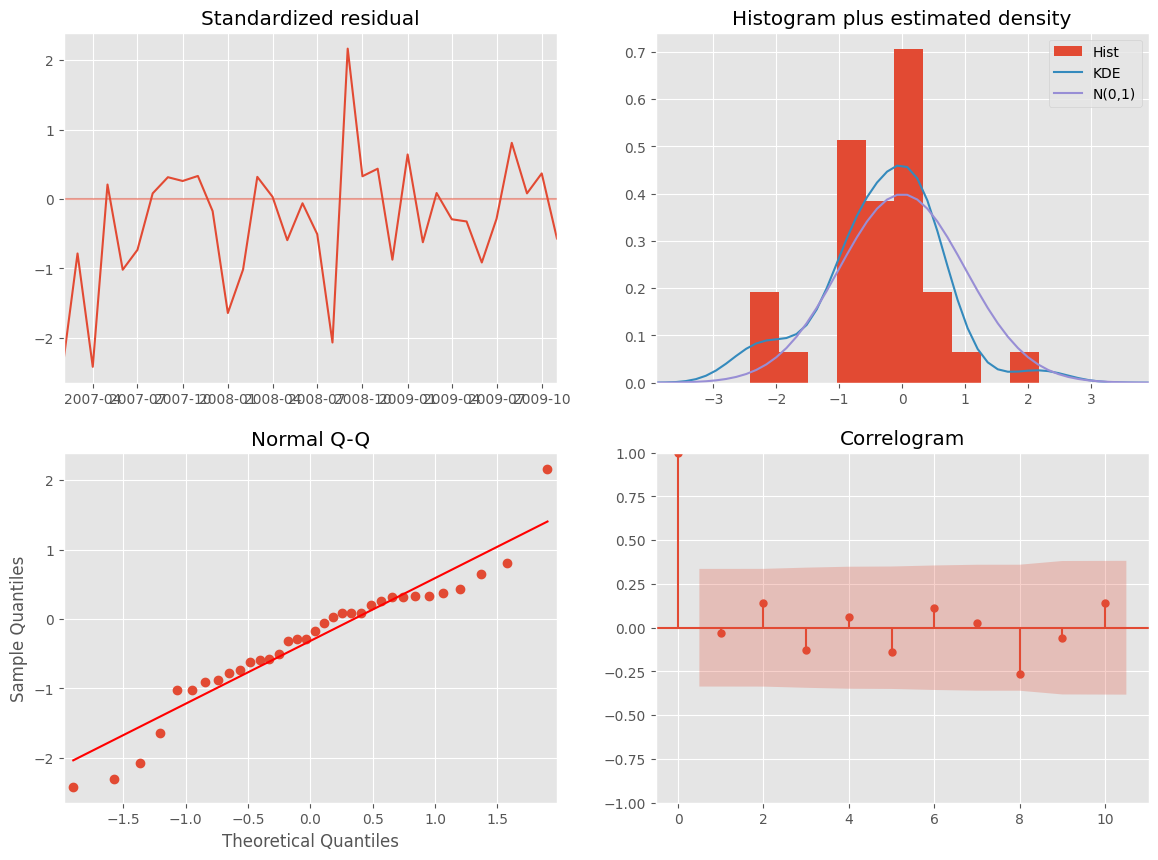

In [22]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

#### Forecasting <a id="forecast"></a>

In [31]:
prediction, confint = model.predict(n_periods = 13, return_conf_int = True) #95% CI default
start = dff_train.index[-1] + pd.DateOffset(months=1)
period_index = pd.period_range(start=start, periods=13, freq='M')
period_index = period_index.to_timestamp()
prediction

2009-12-01    47875.558548
2010-01-01    50908.096126
2010-02-01    46581.165852
2010-03-01    48996.952050
2010-04-01    47499.320301
2010-05-01    46555.393195
2010-06-01    42642.469000
2010-07-01    40962.032487
2010-08-01    42186.285638
2010-09-01    48122.953618
2010-10-01    52070.956139
2010-11-01    51677.499947
2010-12-01    52103.899170
Freq: MS, dtype: float64

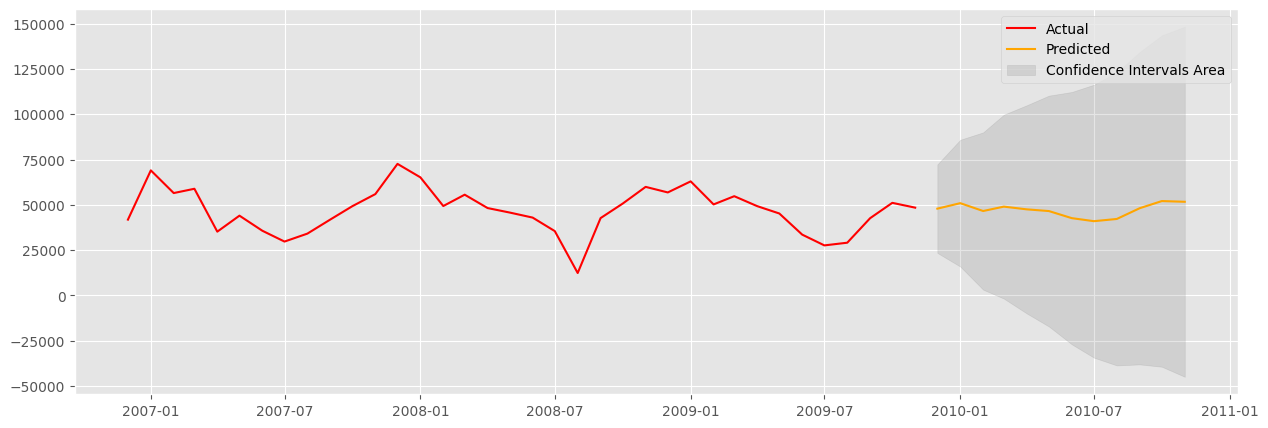

In [24]:
cf= pd.DataFrame(confint)

prediction_series = pd.Series(prediction,index=period_index)
plt.figure(figsize=(15, 5))
plt.plot(dff_train, color='red', label='Actual')
plt.plot(prediction_series, color='orange', label='Predicted')
plt.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.2, label='Confidence Intervals Area')
plt.legend()
plt.show()

#### Model evaluation <a id="evaluation"></a>

#### Visualisation of monthly sold products <a id="test-month"></a>

In [25]:
train['Date'] = pd.to_datetime(train.index)
test['Date'] = pd.to_datetime(test.index)
train['Global_active_power'] = pd.Series(train['Global_active_power'], dtype='float64')
test['Global_active_power'] = pd.Series(test['Global_active_power'], dtype='float64')

In [26]:
test['Date'] = test['Date'].apply(lambda x: datetime.datetime.strptime(x.strftime('%m/%d/%Y'), '%m/%d/%Y'))

#save a copy of sales_train
df_test=test.copy()
# Set the date column as the index of DataFrame 


In [27]:
df_test['month'] = df_test['Date'].dt.to_period('M')
df_test['month'] = df_test['month'].astype(str)
dff2=df_test.copy()
df_test['month'] = pd.to_datetime(df_test['month'])

In [28]:
dff_test = df_test.groupby(['month']).agg({'Global_active_power':'sum'})
dff_test['month'] = dff_test.index
dff_test.drop(['month'],axis=1,inplace=True)
dff_test.rename(columns = {'Global_active_power':'Global_active_power_month'}, inplace = True)

In [32]:
from sklearn.metrics import mean_squared_error

# Giá trị thực tế
actual_values = dff_test # Dữ liệu thực tế của 12 quan sát tiếp theo

# Giá trị dự đoán từ mô hình SARIMA
predicted_values = prediction

# Tính giá trị RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

print("RMSE:", rmse)

RMSE: 15525.002395949683


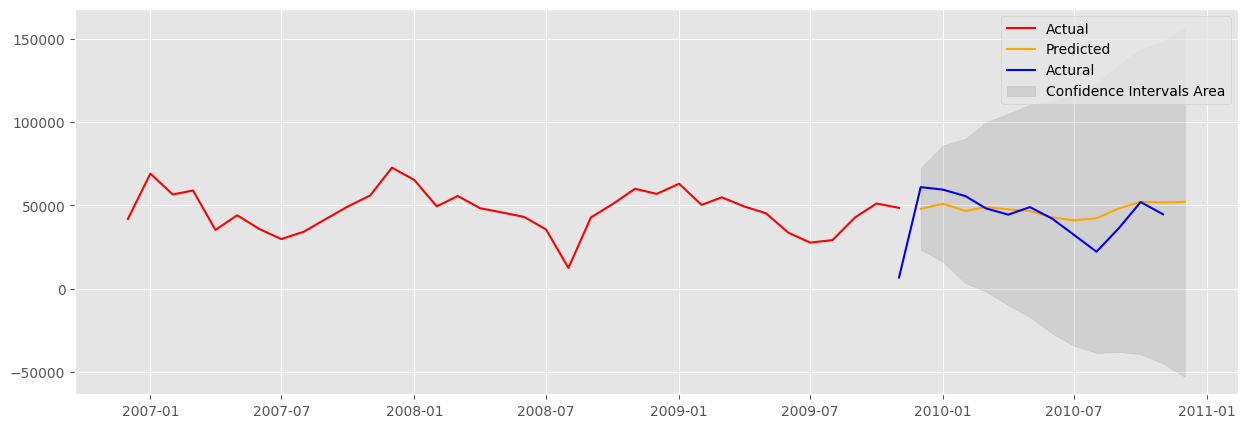

In [33]:
cf= pd.DataFrame(confint)

prediction_series = pd.Series(prediction,index=period_index)
plt.figure(figsize=(15, 5))
plt.plot(dff_train, color='red', label='Actual')
plt.plot(prediction_series, color='orange', label='Predicted')
plt.plot(dff_test, color='blue', label='Actural')
plt.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.2, label='Confidence Intervals Area')
plt.legend()
plt.show()